## Road Marking Monitoring for Smart Cities
    
### Alexander Jung$^{1,2}$, Jyoti Prasad Bartaula$^{1}$, Sangam Deuja$^{1}$
$^{1}$Integrify ry, Helsinki, Finland
<br><br>
$^{2}$Department of Computer Science, Aalto University, Finland 

**Abstract**—We study machine learning methods for monitoring
the condition of road markings in the city of Helsinki.
The monitoring is based on the open geoinformation service
https://kartta.hel.fi. This service provides building maps as
well as orthophotos which are collected on a regular basis.
The resulting methods and datasets are made available
openly under https://github.com/alexjungaalto/ResearchPublic/tree/master/RoadMarkingHelsinki.

## 1. Introduction

Road markings are an important component of the
infrastructure in modern cities. Carefully planned road markings
allow for traffic management and urban planning. In order to fully 
utilize the desired effect of road markings, it is important
to continuously monitor their condition in order to schedule road 
maintenance early on. 

Having accurate
information about the current status of road markings is also
instrumental for driver assistance and autonomous driving
systems. <br>
This paper surveys different methods from machine learning
that allow to monitor the condition of road markings in the
city region of Helsinki. These methods are fed with data that is
available via the open map service https://kartta.hel.fi. Beside
aerial photographs, this service also provides
access to city planning information such as building maps 
and plans of road infrastructure. These different types of 
information constitute various layers that can be superimposed 
for a particular geographical area. 

<br>
<figure>
    <img src="out.jpg" alt='missing' width='300'/>
    <br>
    <figcaption style="text-align:center;">Fig. 1. Aerial photograph of a region within the Helsinki city area.</figcaption>
</figure>

<a id='LoadDataset'></a>
<div class=" alert alert-info">
    <b>Demo.</b> The code snippet below imports all required packages (libraries) and established a connected to the geoinformation server kartta.hel.fi.

</div>

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import datetime
import numpy as np
import cv2
import pandas as pd 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from owslib.wms import WebMapService
from skimage.feature import hog
import io

wms = WebMapService('https://kartta.hel.fi/ws/geoserver/avoindata/wms', version='1.1.1')


# define the bounding box of the entire city area 

xmin = 24.92
ymin = 60.15
xmax = 24.99
ymax = 60.20

# we divide the entire city area evenly into nr_patches_x x nr_patches_y square patches 

nr_patches_x = 50 
nr_patches_y = 50 

patch_x = (xmax-xmin)/nr_patches_x  # width of an individual patch
patch_y = (ymax-ymin)/nr_patches_y  # height of a single patch 

<a id='LoadDataset'></a>
<div class=" alert alert-info">
    <b>Demo.</b>  
  
<p>
The code snippet below reads in the information about one particular patch of the Helsinki city area. It then depicts an aerial photograph and the building map for this patch. 
</p>

</div>

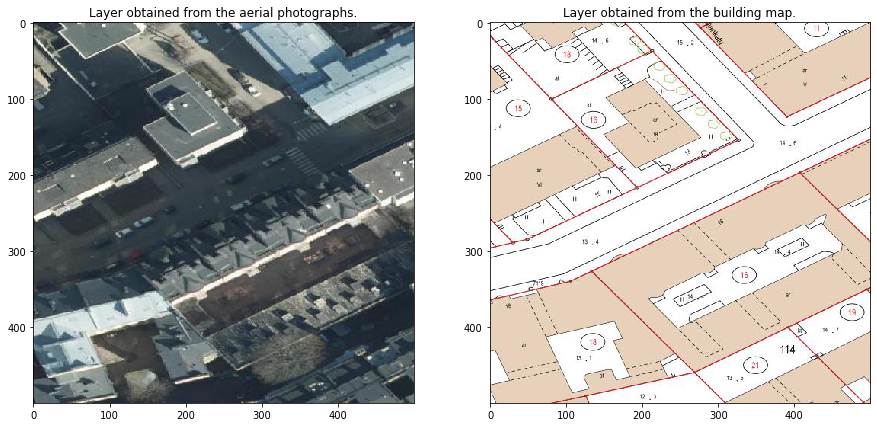

In [9]:
# choose one particular patch 

nr_x = 11 
nr_y = 10

# determine the bounding box for this particular patch 

patch_box = (xmin+nr_x*patch_x,ymin+nr_y*patch_y,xmin+(nr_x+1)*patch_x,ymin+(nr_y+1)*patch_y) 

ortholayer = 'avoindata:Ortoilmakuva_2019_5cm' # choose layer with aerial photographs 
cs = 'EPSG:4326'
resx=500    # choose number of pixels in one direction 
res = (resx,resx)

fig, axes = plt.subplots(1, 2, figsize=(15, 15))

img = wms.getmap(layers=[ortholayer],srs=cs,bbox=patch_box,size=res,format='image/jpeg',transparent=True)
A_1 = np.asarray(Image.open(io.BytesIO(img.read())))
axes[0].imshow(A_1)
axes[0].set_title("Layer obtained from the aerial photographs.") 


img = wms.getmap(layers=['Karttasarja'],srs=cs,bbox=patch_box,size=res,format='image/jpeg',transparent=True)
A_1_layer_1 = np.asarray(Image.open(io.BytesIO(img.read())))
axes[1].imshow(A_1_layer_1)
axes[1].set_title("Layer obtained from the building map.") 

plt.show()

## 2. Problem Formulation

We represent a pedestrian crossing by a feature vector which is obtained from the aerial photographs avaialbe at kartta.hel.fi. This service also provides a list of documented pedestrian crossings with feature vectors $\mathbf{x}^{(1)},\ldots,\mathbf{x}^{(m)}$ with sample size $m$ slightly more than $1300$. In order to identify pedestrian crossings which might need maintenance work, we use clustering methods to group the feature vectors into few clusters. We expect that regular pedestrian crossings will form a well-connected large dominant cluster. The anomolous pedestrian crossings are then found via the feature vectors not belonging to the dominant cluster. 

## 3. Getting The Data

The geographic information service https://kartta.hel.fi provides the locations of documented 
pedestrian crossings (see Figure 5).
<br>
<br>
<figure>
    <img src="SnapshotPedestrianCrossing.jpg" alt='missing' width='300'/>
    <br>
    <figcaption style="text-align:center;">Fig. 5. Aerial photograph of a small region (patch) within Helsinki city area. The red circles indicate 
	pixels belonging to a pedestrian crossing.</figcaption>
</figure>
<br>
<br>
We have obtained the bounding boxes for $m$ 
regions that should depict road markings. The resulting $m$ images are represented by their feature 
vectors $\mathbf{x}^{(1)},\ldots,\mathbf{x}^{(m)}$.<br>
<figure>
    <img src="1.PNG" alt='missing' width='300'/>
    <figcaption style="text-align:center;">Fig. 6. Four regions that have been documented at https://kartta.hel.fi as including a pedestrian crossing.</figcaption>
</figure>
<br>

<a id='ReadCrossings'></a>
<div class=" alert alert-info">
    <b>Demo.</b> The code snippet below fetches image patches depicting pedestrian crossings whose bounding boxes are listed in the file 'klinj_suojatie.gpkg' that has been downloaded from kartta.hel.fi. The downloaded image patches are stored as jpg files in a subfolder of "PedestrianCrossingImg/". A separate subfolder is crated for images obtained from a particular layers (such as aerial photographs or building maps). 
</p>

</div>

In [10]:
import geopandas
import fiona
import pandas as pd
import numpy as np
from owslib.wms import WebMapService
import os

file=geopandas.read_file("klinj_suojatie.gpkg")
df=pd.DataFrame(file)
df.geometry=df.geometry.astype("str")
df["geometry"]=df["geometry"].str.replace("LINESTRING ","").str.replace(",","").str.replace("(","").str.replace(")","")

df[["min_x","max_y","max_x","min_y","a","b"]]=df["geometry"].str.split(" ",expand=True)
df=df.drop(columns=["a","b","geometry"])
df["id"]=df["gml_id"].str.replace("klinj_suojatie.","")

df["min_x"]=df["min_x"].astype(float)
df["min_y"]=df["min_y"].astype(float)
df["max_x"]=df["max_x"].astype(float)
df["max_y"]=df["max_y"].astype(float)

# Fixing inconsistencies 
df.min_x, df.max_x = np.where(df.min_x > df.max_x, [df.max_x, df.min_x], [df.min_x, df.max_x])
df.min_y, df.max_y = np.where(df.min_y > df.max_y, [df.max_y, df.min_y], [df.min_y, df.max_y])


resolution = 100 


# choose layers which are used for the pedestrian crossing images 

layer = "Ortoilmakuva_2019_5cm"

#layer = "Vaaravariortoilmakuva_2019_20cm"

folder_name ="PedestrianCrossingImg/resolution_"+str(resolution)+"_layer_"+layer+"/" 


if not os.path.exists(folder_name):
    os.makedirs(folder_name)


filelist=os.listdir(folder_name)
nrfiles = len(filelist)

if nrfiles < 100 : 

    wms = WebMapService('https://kartta.hel.fi/ws/geoserver/avoindata/wms', version='1.3.0')

    for i in range(0,len(df)):
        # determine bounding box of ith pedestrian crossing 
        minx = df.loc[i,"min_x"] 
        miny = df.loc[i,"min_y"]
        maxx = df.loc[i,"max_x"]
        maxy = df.loc[i,"max_y"]
        deltax = (maxx-minx)
        deltay = (maxy-miny)
        roi = (minx-deltax,miny-deltay,maxx+deltax,maxy+deltay)
    
        #read in image patch from server
 
        img=wms.getmap(layers=[layer],srs="EPSG:3879",bbox=roi,size=(resolution,resolution),format='image/png',transparent=True)
        filename =folder_name + str(df.loc[i,"id"])+".png"
        #filename  = "pedestrian_crossing" + str(i)+".png"
        out = open(filename, 'wb')
        out.write(img.read())
        out.close()



## 4. Feature Extraction


<a id='CrossingsFeatureMatrix'></a>
<div class=" alert alert-info">
    <b>Demo.</b> The code snippet below constructs a feature matrix whose rows contain feature vectors for each pedestrian crossing image. We experiment with different feature extractors such as edge detectors ("CANNY" algorithm) and thresholding based on grayscale level (road markings are typically more white than surrounding). 
</p>

</div>

In [11]:
def applycanny(image):
    img = cv2.imread(image)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    averagegray = np.sum(gray)/(gray.shape[0]*gray.shape[1])
    edge=cv2.Canny(gray, 5, 200,apertureSize=3,L2gradient=True)
    bgr_edge=cv2.cvtColor(edge,cv2.COLOR_GRAY2BGR)
    return np.hstack((img,bgr_edge))  

In [12]:
def cannyplusthreshold(image):
    img = cv2.imread(image)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    averagegraylevel = np.sum(gray)/(gray.shape[0]*gray.shape[1])
    edge=cv2.Canny(gray, 5, 200,apertureSize=3,L2gradient=True)
    bgr_edge=cv2.cvtColor(edge,cv2.COLOR_GRAY2BGR)
    thresh, blackAndWhiteImage=cv2.threshold(gray,averagegraylevel,255, cv2.THRESH_BINARY)
    #thresh_img=cv2.cvtColor(blackAndWhiteImage,cv2.COLOR_GRAY2BGR)
    return np.hstack((gray,edge,blackAndWhiteImage)) 

(1393, 100, 300)


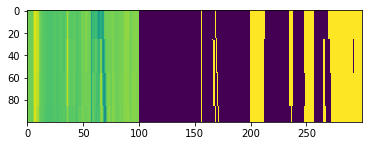

In [13]:
resolution = 100 

layer = "Ortoilmakuva_2019_5cm"
# layer = "Vaaravariortoilmakuva_2019_20cm"

folder ="PedestrianCrossingImg/"+"resolution_"+str(resolution)+"_layer_"+layer


# read in all png files in the directory "folder"

filelist=os.listdir(folder)
for fichier in filelist:
    if not(fichier.endswith(".png")):
        filelist.remove(fichier)

# read in the png images as rgb arrays and store them in im_array

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
ims_rgb = [read(os.path.join(folder, filename)) for filename in filelist]

ims = [cannyplusthreshold(os.path.join(folder, filename)) for filename in filelist]
im_array= np.array(ims, dtype='uint8')
#im_array.shape

#im_array = np.array(ims, dtype='uint8')


print(im_array.shape)

nrsamples = im_array.shape[0]   # total number of png images
pixelsx = im_array.shape[1]     # number of pixels in x-direction
pixelsy = im_array.shape[2]     # number of pixels in y-direction
#channels = im_array.shape[3]    # number of colour channels (3)
channels = 1 

X=im_array.reshape(nrsamples,pixelsx*pixelsy*channels)

matrix = im_array[1,:,:]; 

imgplot = plt.imshow(matrix)
plt.show()


## 5. Dimensionality Reduction

The $i$th pedestrian crossing (image) is characgerized by the feature vector $\mathbf{x}^{(i)}$. In order to find anomalous pedestrian crossings, we first reduce the dimensionality using some dimensionality reductino method. This results in representing each pedestrian crossing by a new feature vector $\mathbf{z}^{(i)} \in \mathbb{R}^{2}$ of length two. 

<a id='TSNE'></a>
<div class=" alert alert-info">
    <b>Demo.</b> The code snippet below applies the t-SNE algorithm to the feature vectors $\mathbf{x}^{(i)}$ to obtain a two-dimensional vector $\mathbf{z}^{(i)}=\big(z^{(i)}_{1},z_{2}^{(i)}\big)^{T}$ which summarizes the relevant properties of the feature vector $\mathbf{x}^{(i)}$. We then construct a scatterplot which represents the $i$-th image using a marker located at the coordinates $z_{1}^{(i)}$ and $z_{2}^{(i)}$.   
</p>

</div>

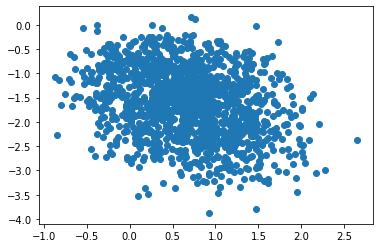

In [14]:
import numpy as np
from sklearn.manifold import TSNE

m = X.shape[0]
n = X.shape[1]

ProjMtx = np.random.randn(n,2)/n

X_embedded = np.matmul(X,ProjMtx) #TSNE(n_components=2).fit_transform(X)

plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.show()

## 6. Clustering 

Using the new feature vectors $\mathbf{z}^{(i)}$, we group the pedestrian crossings using the clustering method DBSCAN into few clusters. The resulting clustering results in one dominant cluster which contains the majority 
of images. We declare the images not belonging to the dominant cluster as anomalous images. 

<a id='DBSCAN'></a>
<div class=" alert alert-info">
    <b>Demo.</b> The code snippet below applies density based clustering (DBSCAN) algorithm to the compressed feature vectors $\mathbf{z}^{(i)}$ which represent the pedestrian crossing images downloaded from kartta.hel.fi. The resulting clustering is then illustrated as a scatter plot. The images forming the largest cluster are declared as regular or non-anomolous and depicted by blue dots. We consider the images outside the largest cluster as anomolous and depict them by red crosses in the scatter plot. The pedestrian crossing images decleared as anomolous are shown below.  
</p>

</div>

cluster indices = [-1  0]
cluster sizes =  [  22. 1371.]


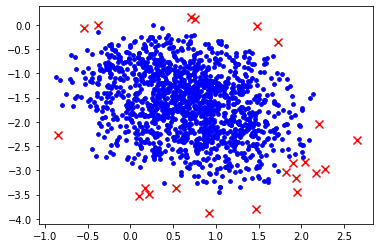

In [16]:
from sklearn.cluster import DBSCAN

# cluster the data points using features X_embedded obtained from t-SNE  
clustering = DBSCAN(eps=.3, min_samples=15).fit(X_embedded)

# determine the cluster sizes 

labels = clustering.labels_ 
labelvals = np.unique(labels)

print("cluster indices =",labelvals)

clustersize = np.zeros(labelvals.shape[0])
for iterval in range(labelvals.shape[0]) : 
     tmp = np.where(abs(labels-labelvals[iterval])< 0.1)
     tmp = tmp[0]
     clustersize[iterval] = tmp.shape[0]

print("cluster sizes = ",clustersize)

# determine largest cluster 

maxlabel = np.argmax(clustersize)


# collect data points outside largest cluster (we consider them outliers)

tmp = np.where(abs(labels-labelvals[maxlabel])> 0.1)
tmp = tmp[0]
outlier= tmp

tmp = np.where(abs(labels-labelvals[maxlabel])< 0.1)
tmp = tmp[0]
inlier= tmp

plt.scatter(X_embedded[outlier,0], X_embedded[outlier,1],  s=64, marker='x',c ='red')
plt.scatter(X_embedded[inlier,0], X_embedded[inlier,1],  s=14, marker='o',c ='blue')
plt.show()

<a id='DBSCAN'></a>
<div class=" alert alert-info">
    <b>Demo.</b> The code snippet below depicts some examples of images which are declared as anomalous via the density based clustering of the compressed feature vectors obtained from t-SNE.
</p>

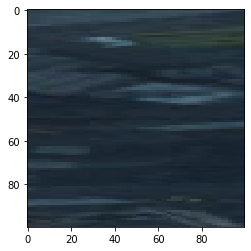

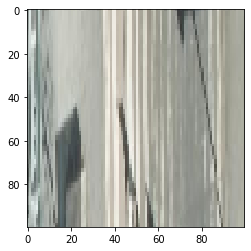

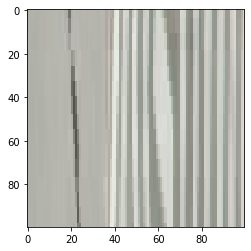

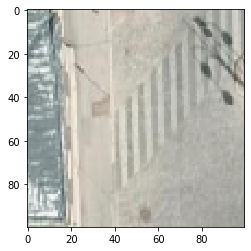

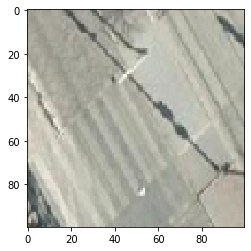

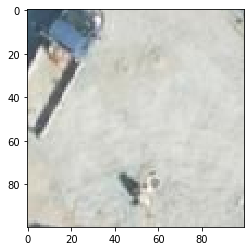

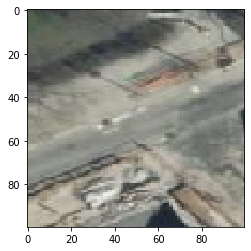

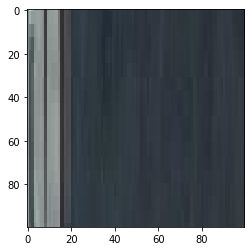

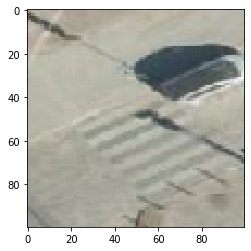

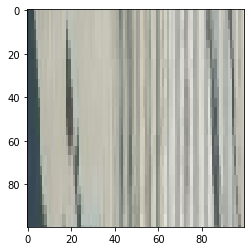

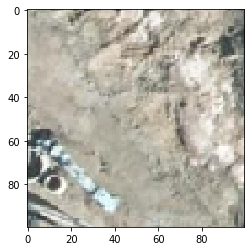

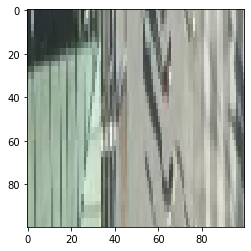

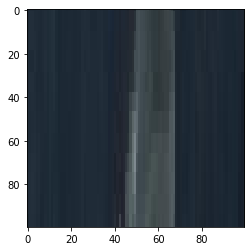

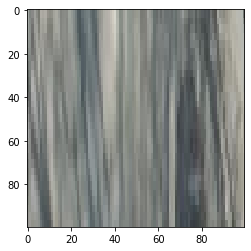

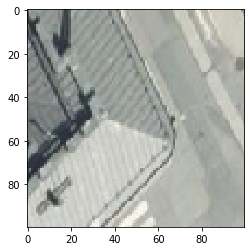

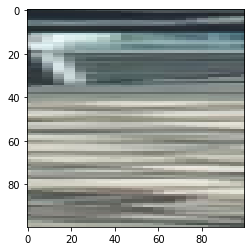

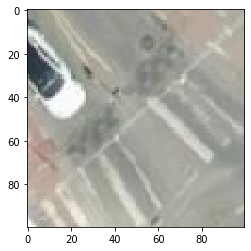

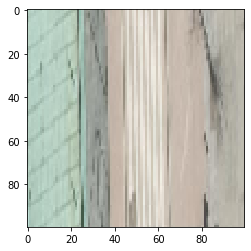

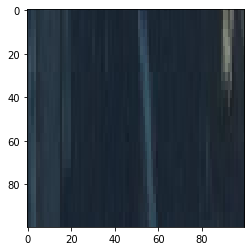

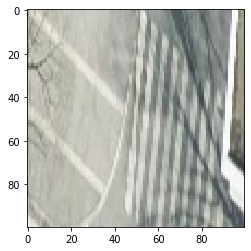

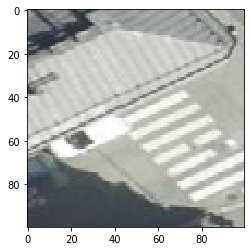

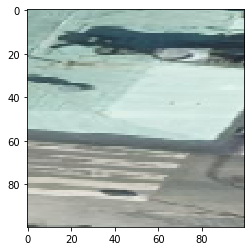

In [17]:
for imgidx in outlier :
    
  #  matrix = im_array[imgidx,:,:]; 
    matrix = ims_rgb[imgidx]
    imgplot = plt.imshow(matrix)
    filename = "outlier" + str(imgidx) +".jpg"
    plt.savefig(filename,dpi=50,transparent=True)
    plt.show()

**References**

B. Mathibela, P. Newman and I. Posner, "Reading the Road: Road Marking Classification and Interpretation," in IEEE Transactions on Intelligent Transportation Systems, vol. 16, no. 4, pp. 2072-2081, Aug. 2015.
doi: 10.1109/TITS.2015.2393715
URL: http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7055289&isnumber=7174612

H. Jin and Y. Feng, "Automated road pavement marking detection from high resolution aerial images based on multi-resolution image analysis and anisotropic Gaussian filtering," 2010 2nd International Conference on Signal Processing Systems, Dalian, 2010, pp. V1-337-V1-341.
doi: 10.1109/ICSPS.2010.5555636 URL: http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=5555636&isnumber=5555236

S. M. Azimi, P. Fischer, M. Körner and P. Reinartz, "Aerial LaneNet: Lane-Marking Semantic Segmentation in Aerial Imagery Using Wavelet-Enhanced Cost-Sensitive Symmetric Fully Convolutional Neural Networks," in IEEE Transactions on Geoscience and Remote Sensing, vol. 57, no. 5, pp. 2920-2938, May 2019.
doi: 10.1109/TGRS.2018.2878510
URL: http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8556373&isnumber=8697166

M. Ester, H.-P. Kriegel, J. Sander, X. Xu: A density-based algorithm for discovering clusters in large spatial databases with noise. In: Evangelos Simoudis, Jiawei Han, Usama M. Fayyad (Hrsg.): Proceedings of the Second International Conference on Knowledge Discovery and Data Mining (KDD-96). AAAI Press, 1996, ISBN 1-57735-004-9, S. 226–231

L.J.P. van der Maaten, G.E. Hinton. "Visualizing Data Using t-SNE". Journal of Machine Learning Research. 9: 2579–2605, Nov. 2008. 

J. Canny, "A Computational Approach to Edge Detection," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. PAMI-8, no. 6, pp. 679-698, Nov. 1986.
doi: 10.1109/TPAMI.1986.4767851

